In [1]:
from xmps.iMPS import iMPS, Map
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eig, expm, null_space
from scipy.optimize import minimize
from functools import reduce 
from xmps.spin import U4
from xmps.tensor import rotate_to_hermitian
from qmps.tools import environment_to_unitary
from qmps.ground_state import Hamiltonian
from itertools import chain
import pickle
import matplotlib.pyplot as plt

# tensor:
"""
                   0      0      j
                   | -U2- |      |
A[i, σ1,σ2, j] =   |      | -U1- |
                   |      |      |
                   i      σ1      σ2
                   
"""

# alternate_tensor:
"""
                   i      0      0
                   |      | -U2- |
A[i, σ1,σ2, j] =   | -U1- |      |
                   |      |      |
                   σ1     σ2     j
"""

Z = np.array([
    [1,0],
    [0,-1]
])

X = np.array([
    [0,1],
    [1,0]
])

I = np.eye(2)

def tensor_prod(tensors):
    return reduce(lambda t1,t2: np.kron(t1,t2), tensors)

# Find the exact right environment:
def merge(A, B):
    # -A- -B-  ->  -A-B-
    #  |   |        ||
    return np.tensordot(A, B, [2, 1]).transpose([0, 2, 1, 3]).reshape(A.shape[0]**2, A.shape[1], A.shape[2])


def tensor(U2, U1):
    """
    Produce a depth 2 tensor A[(σ1σ2),i,j]:
    
    A[σ1σ2,i,j] = Σα U1[σ1,σ2,α,j]U2[i,α,0,0]
    """
    
    return depthNtensor([U2,U1])

 
def depthNtensor(N_Us):
    # depth N
    N = len(N_Us)
    N_Us = map(lambda a: a.reshape(2,2,2,2), N_Us)
    # number indices after contraction
    ni = 2+2*N
    
    # bond dimension
    d = 2**(N - 1)
    
    # corresponds to the iₐ indices - reversed list of odd indices between 3 and ni-3 inclusive 
    i_indices = [i for i in reversed(range(3,ni-2,2))]
    
    # corresponds to the jₐ indices - reversed list of even indices between 2 and ni-4 inclusive
    j_indices = [j for j in reversed(range(2,ni-3,2))]
    
    # add the physical indices, [0,1], to the auxillary indices, and then the indices set to 0s
    indices = [0,1] + i_indices + j_indices + [ni-2, ni-1]
    
    # Tensordot all the tensors together in the order:
    #    1: UN-1, UN = A1
    #    2: UN-2, A1 = A2
    #    3  UN-3, A2 = A3, ...
    # Then reshape into the index order specified by indices
    A = reduce(lambda a,b: np.tensordot(b, a, [2,1]), N_Us).transpose(*indices).reshape(4,d,d,4)[...,0]
    
    return A


def RightEnv(Us, Ūs, Ut):
    """
    Return the exact right environment, given a set of Us = [UN,UN-1,...] and Ūs = [ŪN, ŪN-1,...]
    """
    A1 = depthNtensor(Us)
    A2 = depthNtensor(Ūs)
    tm = Map(np.tensordot(Ut, merge(A1, A1), [1,0]), merge(A2,A2))
    ηr, r = tm.right_fixed_point()
    return ηr, r


def exact_right_env(U2,U1,Ū2,Ū1, Ut, time_evo_in = False):
    if time_evo_in:
        return RightEnv([U2, U1], [Ū2, Ū1], Ut)
    
    else:
        return RightEnv([U2, U1], [Ū2, Ū1], np.eye(16))


# Compare to the right environment that you get from trivial with adjustment:

def alternate_tensor(U2, U1):
    """
    Produce a tensor A[(σ1σ2),i,j]:
    
    A[(σ1σ2),i,j] = Σα U1[σ1,σ2,i,α]U2[α,j,0,0]
    """
    
    return np.tensordot(
        U1.reshape(2,2,2,2),
        U2[:,0].reshape(2,2),
        (3,0)).reshape(4,2,2)

def adjust_trivial_environment(U2,Ū2,mr):
    """
    Adjust the trivial environment with a matrix, mr:
    
    0      0
    | -U2- |
    |(3)   |
    i      |(2)
           mr
    j(0)   |(1)
    |      |
    | -Ū2- |
    0      0
    
    It is not clear why we have to transpose the mr matrix.
    """
    Rᵢⱼ = np.einsum(
        Ū2.conj().T[0,:].reshape(2,2), [0,1],  
        mr.T,                          [1,2],
        U2[:,0].reshape(2,2),          [3,2],
        [3,0])
    
    
    return rotate_to_hermitian(Rᵢⱼ) /(np.sign(Rᵢⱼ[0,0]) * np.linalg.norm(Rᵢⱼ))

def right_env(U2,U1,Ū2,Ū1):
    A1 = alternate_tensor(U2,U1)
    A2 = alternate_tensor(Ū2,Ū1)
    
    alt_tm = Map(A1,A2)
    
    η, mr = alt_tm.right_fixed_point()
    
    R = adjust_trivial_environment(U2,Ū2,mr)
    return R

def put_env_on_left_site(q, ret_n=False):
    # Take a matrix q (2x2) and create U such that 
    # (right 0-|---|--0
    #          | u |        =  q_{ij}
    # (left) i-|---|--j 
    q = q.T
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, c.conj(), b, d.conj()], [c, -a.conj(), d, -b.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    A = cirq.unitary(cirq.SWAP)@A
    if ret_n:
        return A, n
    else:
        return A
    
def get_env_off_left_site(A):
    z = np.array([1, 0])
    return np.tensordot(np.tensordot(A.reshape(2, 2, 2, 2), z, [3, 0]), z, [1, 0]).T

def put_env_on_right_site(q, ret_n=False):
    q = q
    a, b, c, d = q.reshape(-1)
    n = np.sqrt(np.abs(a)**2+ np.abs(c)**2+ np.abs(b)**2+ np.abs(d)**2)
    guess = np.array([[a, b, d.conj(), -c.conj()], [c, d, -b.conj(), a.conj()]])/n
    orth = null_space(guess).conj().T
    A = np.concatenate([guess, orth], axis=0)
    
    if ret_n:
        return A, n
    else:
        return A

    # Cirq Code:

import cirq 
from qmps.represent import ShallowFullStateTensor, Environment, FullStateTensor, Tensor

class ShallowFullStateTensor(cirq.Gate):
    def __init__(self, bond_dim, βγs, symbol='U'):
        self.βγs = βγs
        self.p = len(βγs)
        self.n_qubits = int(np.log2(bond_dim)) + 1
        self.symbol = symbol

    def num_qubits(self):
        return self.n_qubits

    def _decompose_(self, qubits):
        return [cirq.rz(self.βγs[0])(qubits[0]), cirq.rx(self.βγs[1])(qubits[0]), cirq.rz(self.βγs[2])(qubits[0]),
                cirq.rz(self.βγs[3])(qubits[1]), cirq.rx(self.βγs[4])(qubits[1]), cirq.rz(self.βγs[5])(qubits[1]),
                cirq.CNOT(qubits[0], qubits[1]),
                cirq.ry(self.βγs[6])(qubits[0]),
                cirq.CNOT(qubits[1], qubits[0]),
                cirq.ry(self.βγs[7])(qubits[0]), cirq.rz(self.βγs[8])(qubits[1]),
                cirq.CNOT(qubits[0], qubits[1]),
                cirq.rz(self.βγs[9])(qubits[0]), cirq.rx(self.βγs[10])(qubits[0]), cirq.rz(self.βγs[11])(qubits[0]),
                cirq.rz(self.βγs[12])(qubits[1]), cirq.rx(self.βγs[13])(qubits[1]), cirq.rz(self.βγs[14])(qubits[1])]

    def _circuit_diagram_info_(self, args):
        return [self.symbol] * self.n_qubits

class Depth2State(cirq.Gate):
    def __init__(self, Us, n = 1):
        assert len(Us) == 2
        self.Us = Us
        self.n_phys_qubits = 2*n
        
    def _decompose_(self, qubits):
        return [self.Us[0](*qubits[n:n+2]) for n in range(0,self.n_phys_qubits,2)] + [self.Us[1](*qubits[n:n+2]) for n in range(1,self.n_phys_qubits+1, 2)]
    
    def num_qubits(self):
        return self.n_phys_qubits + 1
    
    def _circuit_diagram_info_(self, args):
        return ["U1,2"] * self.num_qubits()
    
class DepthNState(cirq.Gate):
    def __init__(self, Us, depth, n=1):
        assert len(Us) == depth
        self.Us = Us
        self.n_phys_qubits = 2*n
        self.depth = depth
        
    def _decompose_(self, qubits):
        list_of_gates = [[self.Us[i](*qubits[n+i:n+i+2]) for n in range(0,self.n_phys_qubits,2)] for i in range(self.depth)]
        return list(chain.from_iterable(list_of_gates))
    
    def num_qubits(self):
        return self.n_phys_qubits + self.depth - 1

    def _circuit_diagram_info_(self, args):
        return ["U"]*self.num_qubits()
        
def build_ciruit(U1, U2, Ū1, Ū2, Ut, time_evo_in = False):
    _,r = exact_right_env(*map(cirq.unitary, [U2,U1,Ū2,Ū1,Ut]), time_evo_in)
    R = Environment(put_env_on_left_site(r),'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')

    State = Depth2State([U2,U1], n = 2)
    S̄ = Depth2State([Ū2,Ū1], n = 2)

    qubits = cirq.LineQubit.range(8)
    circuit = cirq.Circuit()
    circuit.append([
        cirq.H.on(qubits[5]),
        cirq.CNOT.on(qubits[5],qubits[6]),
        State.on(*qubits[1:6]),
        L.on(*qubits[0:2]),
        Ut.on(*qubits[2:6]),
        R.on(*qubits[6:8]),

        cirq.inverse(S̄.on(*qubits[1:6])),
        cirq.CNOT.on(qubits[5],qubits[6]),
        cirq.H.on(qubits[5])
    ])
    
    return circuit


def build_noenv_circuit(U1, U2, Ū1, Ū2, Ut):
    Ū2inv = cirq.inverse(Ū2)
    Ū1inv = cirq.inverse(Ū1)
    
    qubits = cirq.LineQubit.range(6)
    circuit = cirq.Circuit()
    
    circuit.append([
        U2.on(*qubits[0:2]),
        U2.on(*qubits[2:4]),
        U2.on(*qubits[4:6]),
        U1.on(*qubits[1:3]),
        U1.on(*qubits[3:5]),
        Ut.on(*qubits[2:6]),
        Ū1inv.on(*qubits[1:3]),
        Ū1inv.on(*qubits[3:5]),
        Ū2inv.on(*qubits[0:2]),
        Ū2inv.on(*qubits[2:4]),
        Ū2inv.on(*qubits[4:6])
    ])
    
    return circuit


def overlap(U1, U2, Ū1, Ū2, Ut, env = True, time_evo_in = False):
    if env:
        circuit = build_ciruit(U1, U2,Ū1, Ū2, Ut, time_evo_in)
    else:
        circuit = build_noenv_circuit(U1, U2,Ū1, Ū2, Ut)
        
    sim = cirq.Simulator()
    return 2*np.abs(sim.simulate(circuit).final_state_vector[0])



def circuit_state(U1, U2, Ū1, Ū2, Ut):
    circuit = build_ciruit(U1, U2, Ū1, Ū2, Ut)
    sim = cirq.Simulator()
    return sim.simulate(circuit).final_state_vector

def State3Vector(U1, U2):
    S = Depth2State([U2,U1], n=2)
    circuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(6)
    circuit.append([
        U2.on(*qubits[4:6]),
        cirq.decompose_once(S.on(*qubits[0:5]))
    ])
    sim = cirq.Simulator()
    return sim.simulate(circuit).final_state_vector

def State2Vector(U1, U2):
    S = Depth2State([U2,U1], n=1)
    circuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(4)
    circuit.append([
        U2.on(*qubits[2:4]),
        cirq.decompose_once(S.on(*qubits[0:3]))
    ])
    sim = cirq.Simulator()
    return sim.simulate(circuit).final_state_vector

def TimeEvoObj(p, U1, U2, Ut, env = True, time_evo_in = False):
    Ū1 = ShallowFullStateTensor(2, p[:15], 'U1')
    Ū2 = ShallowFullStateTensor(2, p[15:], 'U2')
    return -overlap(U1, U2, Ū1, Ū2, Ut, env, time_evo_in)

def EnergyObj(p, H):
    U1 = ShallowFullStateTensor(2, p[:15], 'U1')
    U2 = ShallowFullStateTensor(2, p[15:], 'U2')
    ψ = State3Vector(U1, U2)
    
    E = np.real(ψ.conj().T @ H @ ψ)
    return E

def Param2State(p):
    U1 = ShallowFullStateTensor(2, p[:15], 'U1')
    U2 = ShallowFullStateTensor(2, p[15:], 'U2')
    return State2Vector(U1, U2)

test_right_env_adjustment = True

if test_right_env_adjustment:
    U2,U1 = [unitary_group.rvs(4), unitary_group.rvs(4)]
    Ū2,Ū1 = [unitary_group.rvs(4), unitary_group.rvs(4)]
    
    _,exact_r = exact_right_env(U2,U1,Ū2,Ū1,np.eye(16))
    print("Exact Right Environment:")
    print(exact_r)
    print("\n")

    adjusted_r = right_env(U2,U1,Ū2,Ū1)
    print("Adjusted Right Environment:")
    print(adjusted_r)

    print("\nWe can see that the adjusted trivial environment gives the correct answer")

Exact Right Environment:
[[ 0.62187235-0.j         -0.29814121+0.11328588j]
 [ 0.26653704-0.5558956j   0.10326524+0.3476022j ]]


Adjusted Right Environment:
[[ 0.62187235-0.j         -0.29814121+0.11328588j]
 [ 0.26653704-0.5558956j   0.10326524+0.3476022j ]]

We can see that the adjusted trivial environment gives the correct answer


In [20]:
# Loschimdt Echos:
from tqdm import tqdm

initial_state = np.random.rand(30)
g0, g1 = 0,2

# Ham = Hamiltonian({"ZZ":-1,"X":g0}).to_matrix()
# H2 = tensor_prod([I,Ham,Ham,I])
# H3 = tensor_prod([I,I,Ham,I,I])
# H23 = (0.5*H2 + H3)

def Ham(J,g):
    return sum([
                (J/3)*sum([
                    tensor_prod([Z,Z,I,I]),
                    tensor_prod([I,Z,Z,I]),
                    tensor_prod([I,I,Z,Z])]),
                (g/4)*sum([
                    tensor_prod([X,I,I,I]),
                    tensor_prod([I,X,I,I]),
                    tensor_prod([I,I,X,I]),
                    tensor_prod([I,I,I,X])
                ])])

from functools import partial
import matplotlib.pyplot as plt

results = []
def print_function(xk, Ham, res):
    E = EnergyObj(xk, Ham)
    res.append(E)
    #print(E)

cb = partial(print_function, Ham = tensor_prod([I,Ham(-1,g0),I]), res = results)

ground_state = minimize(
    EnergyObj,
    x0 = initial_state,
    method = "Powell",
    args = (tensor_prod([I,Ham(-1,g0),I]),),
    callback = cb,
    tol=1e-8,
)

print(np.linalg.eigvals(Ham(-1,g0)))

print(ground_state.fun)
# plt.plot(results)

# with open("g0-15-LoschmidtGroundStateParams.pkl","wb") as f:
#     pickle.dump(ground_state.x, f)


# STEPS = 5
# DT = 0.00

# Ut = FullStateTensor(expm(-1j * Ham(-1,g1) * DT))

# params = []
# init_param = ground_state.x
# for _ in tqdm(range(STEPS)):
#     params.append(init_param)
#     U1 = ShallowFullStateTensor(2, init_param[:15], 'U1')
#     U2 = ShallowFullStateTensor(2, init_param[15:], 'U2')

#     next_step = minimize(
#         TimeEvoObj,
#         x0 = init_param,
#         method = "Nelder-Mead",
#         args = (U1, U2, Ut, True, True),
#         options = {"disp":True,"maxiter":50}
#     )
    
#     init_param = next_step.x
assert np.allclose(ground_state.fun, -1)



[-1.         -0.33333333  0.33333333 -0.33333333  0.33333333  1.
  0.33333333 -0.33333333 -0.33333333  0.33333333  1.          0.33333333
 -0.33333333  0.33333333 -0.33333333 -1.        ]
-0.9999965934100974


In [22]:
np.allclose(ground_state.fun, -1)


True

In [136]:
# Compare Joint Cost Function vs Conditional Cost Function:
U1 = FullStateTensor(unitary_group.rvs(4))
Ū1 = FullStateTensor(U1._unitary_())
U2 = FullStateTensor(unitary_group.rvs(4))
Ū2 = FullStateTensor(U2._unitary_())

circuit = build_ciruit(U1,U2,Ū1,Ū2,FullStateTensor(np.eye(16)))
circuit.append([cirq.measure(*circuit.all_qubits())])

REPS = 100000
samples = cirq.sample(circuit, repetitions=REPS)
ψ = samples.measurements['5,4,3,2,1,0,7,6']
# Qubit ordering is as follows: "5,4,3,2,1,0,7,6"

# 0e is measuring the end qubits as 0
# Joint Prob = P(0e,0,...,0,0e) 
JP = sum(np.all(ψ == 0, axis=1))/REPS
print("Joint Probability: ", JP)

# # Conditional Probability = P(0,0,...,0| 0e,0e) = P(0e,0,...,0,0e) / P(0e,0e)
# # ψ is length 256. The first qbuit is in zero in the first 128 values. Then alternating values have the end qubit
# #    in the zero state. So we want the 0th, 2nd, 4th,...128th values

CP = REPS * JP / sum((ψ[:,6] == 0)[ψ[:,5] == 0])
print("Conditional Probability: ", CP)

print(JP / CP)

Joint Probability:  0.25075
Conditional Probability:  0.5413662075219137
0.46318


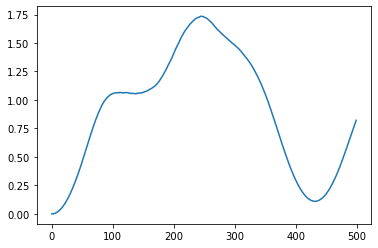

In [2]:
## Plot Loschmidt
from xmps.iMPS import iMPS

def LoschmidtOverlap(p0,params):
    U1 = cirq.unitary(ShallowFullStateTensor(2, p0[:15], 'U1'))
    U2 = cirq.unitary(ShallowFullStateTensor(2, p0[15:], 'U2'))
    
    Ū1 = cirq.unitary(ShallowFullStateTensor(2, params[:15], 'U1'))
    Ū2 = cirq.unitary(ShallowFullStateTensor(2, params[15:], 'U2'))
    
    A = iMPS([tensor(U2,U1)]).left_canonicalise()
    Ā = iMPS([tensor(Ū2,Ū1)]).left_canonicalise()
    
    return -np.log(np.abs(A.overlap(Ā)))
    

def PlotLoschimdt(param_results):
    p0 = param_results[0]
    
    results = []
    for p in param_results:
        results.append(LoschmidtOverlap(p0,p))
        
    plt.plot(results)

# These are for the exact ground state examples
noEnv = "./g00g12NoEnvLoschmidt.pkl"       #no environment 
exactEnv = "./g00g12ExactEnvLoschmidt.pkl" # environment with time evolution in the right environment
exactEnvNoTime = "g00g12ExactEnvNoTimeEvoLoschmidt.pkl" # env without time evolution
    
with open(exactEnvNoTime, "rb") as f:
    yes = pickle.load(f)    

PlotLoschimdt(yes)

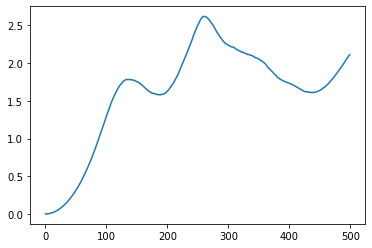

In [6]:
with open(noEnv, "rb") as f:
    no = pickle.load(f)    

PlotLoschimdt(no)

In [17]:
from scipy.integrate import quad
def f(z, g0, g1):
    def theta(k, g):
        return np.arctan2(np.sin(k), g-np.cos(k))/2
    def phi(k, g0, g1):
        return theta(k, g0)-theta(k, g1)
    def epsilon(k, g1):
        return -2*np.sqrt((g1-np.cos(k))**2+np.sin(k)**2)
    def integrand(k):
        return -1/(2*np.pi)*np.log(np.cos(phi(k, g0, g1))**2 + np.sin(phi(k, g0, g1))**2 * np.exp(-2*z*epsilon(k, g1)))

    return quad(integrand, 0, np.pi)[0]


def loschmidt(t, g0, g1):
    return (f(t*1j, g0, g1)+f(-1j*t, g0, g1))

g0, g1 = 0, 2
T = np.linspace(0,3,1000)
Q = [loschmidt(t, g0, g1) for t in T]


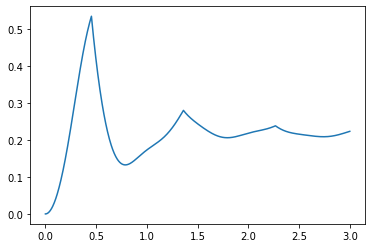

In [18]:
plt.plot(list(T),Q)